# Bed simulation

In [1]:
"""
Bed counter-factual Simulation

Covers:

- Resources: Resource
- Resources: Container
- Waiting for other processes

Scenario:
    We are trying to assess if using a non-greedy approach would
     reduce the number of patients boarded to the wrong ward

- A patient arrives at the beds_correct - the logic!
beds = simulated_beds + remaining_beds

# If there are no beds in the correct specialty area irl
if remaining_beds=0:
    boarded = True
else:
    boarded = False
# If there are no beds in the simulation for the correct specialty area
if beds > 0 | predicted_board:
    simulation_boarded = True
else:
    simulation_boarded = False

if simulation_boarded & boarded:
    wait for a bit
    leave
if simulation_boarded & not boarded:
    increment simulated beds
    wait for a bit
    leave
if not simulation_boarded & boarded:
    decrement simulation beds
    wait for a bit
if not simulation_boarded & not boarded:  # repeated for readability...
    wait for a bit
    leave
"""
import itertools
import random
import pandas as pd

import simpy


RANDOM_SEED = 42
T_INTER = [5, 20]        # Create a patient every [min, max] minutes
SIM_TIME = 60*12*7          # Simulation time in minutes
NUMBER_OF_BEDS = 200

df = pd.read_csv('data.csv')
df['predicted_boarded'] = False
patients = df.to_dict(orient='records')

# Toy data
#patients = [{'transfers.subject_id': 1, 'icustay_los_total': 50, 'remaining_beds': 6, 'predicted_boarded': False},
#            {'transfers.subject_id': 2, 'icustay_los_total': 30, 'remaining_beds': 6, 'predicted_boarded': False}]


global simulated_beds
simulated_beds = 10
mortalityStore = []
agreementStore = []

def patient(env, beds_correct, **p):
    global simulated_beds
    print('%s arriving at ICU at %.1f' % (p['transfers.subject_id'], env.now))

    beds = simulated_beds + p['remaining_beds']
    if p['remaining_beds'] == 0:
        boarded = True
    else:
        boarded = False

    # If there are no beds in the simulation for the correct specialty area
    if beds < 0 | p['predicted_boarded']:
        simulation_boarded = True
        print("Decision made")
        print(beds)
    else:
        simulation_boarded = False

    if simulation_boarded & boarded:
        print("Agreed boarding")
        agreementStore.append("Agreed boarding")
        mortalityStore.append(p['days_survived'])
        with beds_correct.request() as req:
            start = env.now
            # Request one of the beds
            yield req
            # Stay in a bed for a bit
            yield env.timeout(p['icustay_los_total'])

            print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))
    elif simulation_boarded & (not boarded):
        print("Disagree boarding")
        agreementStore.append("Disagree boarding")
        mortalityStore.append(p['days_survived'])
        with beds_correct.request() as req:
            start = env.now
            simulated_beds += 1
            # Request one of the beds
            yield req
            # Stay in a bed for a bit
            yield env.timeout(p['icustay_los_total'])
            #simulated_beds -= 1

            print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))
    elif (not simulation_boarded) and boarded:
        print("Disagree not boarding")
        agreementStore.append("Disagree not boarding")
        mortalityStore.append(p['days_survived'])
        with beds_correct.request() as req:
            start = env.now
            simulated_beds -= 1
            # Request one of the beds
            yield req
            # Stay in a bed for a bit
            yield env.timeout(p['icustay_los_total'])
            #simulated_beds += 1

            print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))
    elif simulation_boarded and boarded:
        print("Agreed not boarding")
        agreementStore.append("Agreed not boarding")
        mortalityStore.append(p['days_survived'])
        with beds_correct.request() as req:
            start = env.now
            # Request one of the beds
            yield req
            # Stay in a bed for a bit
            yield env.timeout(p['icustay_los_total'])

            print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))




def patient_generator(env, beds_correct, patients):
    """Generate new patient that arrive at the ICU."""
    for i in itertools.count():
        yield env.timeout(random.randint(*T_INTER))
        p = random.sample(patients, 1)[0]
        #print_name = 'Simulation id {}'.format(i) #, Data id  %s' % (i, p['transfers.subject_id'])
        env.process(patient(env, beds_correct, **p))


# Create environment and start processes
env = simpy.Environment()
beds_correct = simpy.Resource(env, NUMBER_OF_BEDS)
#bed_boarded = simpy.Resource(env, 1, NUMBER_OF_BEDS)
env.process(patient_generator(env, beds_correct, patients)) #beds_boarded,

# Execute!
env.run(until=SIM_TIME)

print(simulated_beds)




/Users/andrevauvelle/anaconda3/envs/flask/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2497 arriving at ICU at 20.0
3506 arriving at ICU at 25.0
14316 arriving at ICU at 30.0
54940 arriving at ICU at 38.0
85845 arriving at ICU at 56.0
11834 arriving at ICU at 61.0
56283 arriving at ICU at 70.0
81902 arriving at ICU at 84.0
12330 arriving at ICU at 96.0
32348 arriving at ICU at 102.0
Disagree not boarding
77924 arriving at ICU at 117.0
25178 arriving at ICU at 130.0
50807 arriving at ICU at 141.0
32348 left ward in 40.4 minutes.
93196 arriving at ICU at 152.0
75100 arriving at ICU at 159.0
24573 arriving at ICU at 174.0
19478 arriving at ICU at 179.0
4096 arriving at ICU at 197.0
76182 arriving at ICU at 213.0
24548 arriving at ICU at 230.0
Disagree not boarding
21150 arriving at ICU at 236.0
54723 arriving at ICU at 256.0
40724 arriving at ICU at 264.0
24548 left ward in 37.1 minutes.
55597 arriving at ICU at 274.0
47263 arriving at ICU at 283.0
5366 arriving at ICU at 296.0
41279 arriving at ICU at 312.0
24978 arriving at ICU at 324.0
21745 arriving at ICU at 335.0
9228

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


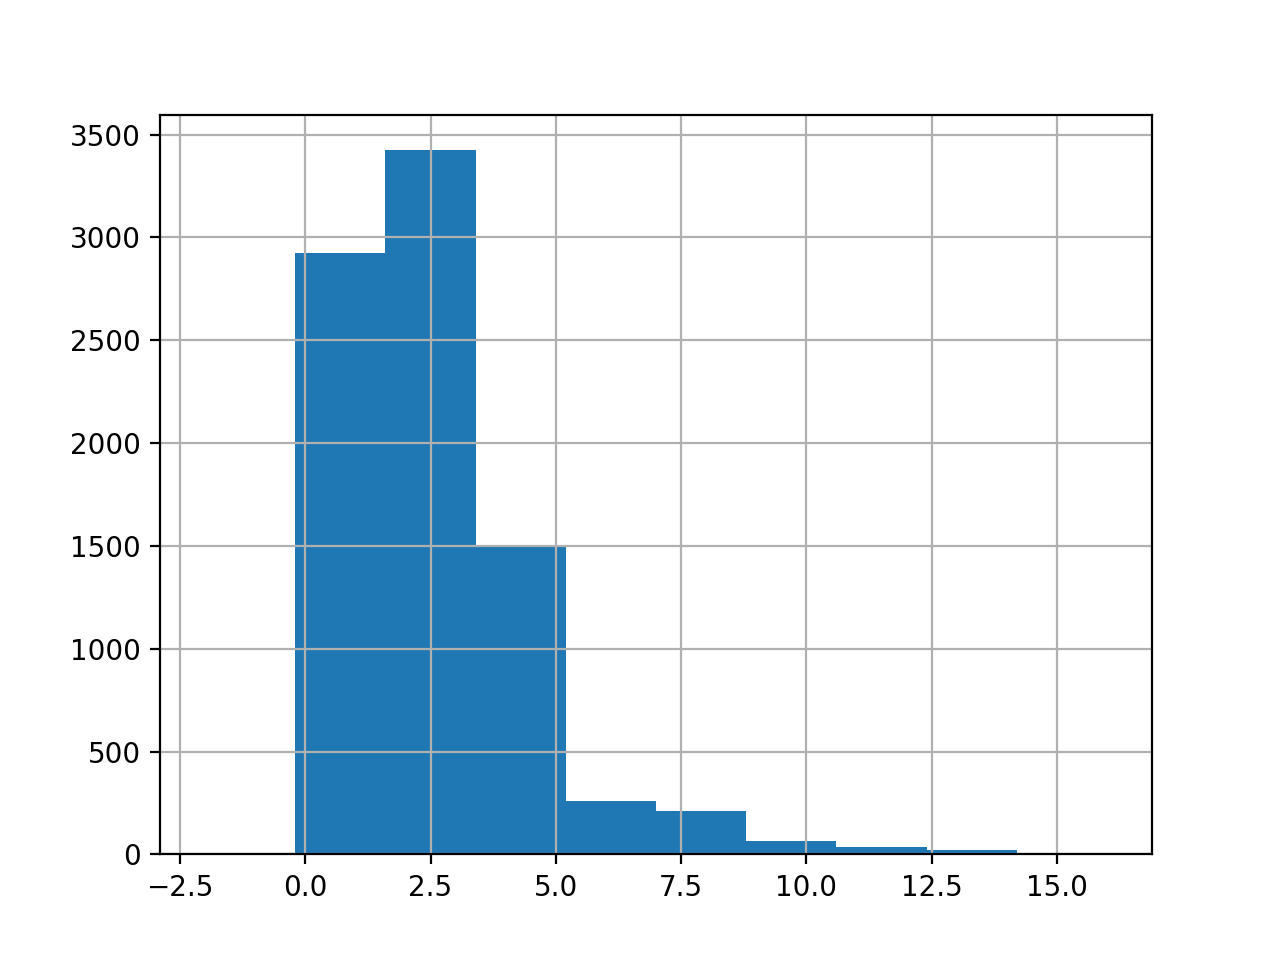

In [5]:
df['remaining_beds'].hist()